# **Data Collection**
---

## Objective

- Clean and prepare the provided image dataset

## Inputs

- A folder containing a specific amount of correctly labeled subfolders corresponding to the amount of pets to distinguish
- Several hundred preprocessed png images (size 450x450) in each subfolder, showing a close-up of the pet's face

## Outputs

- A cleaned dataset in the folder `inputs/datasets/pets` split into `train`/`validation`/`test` subfolders

---

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
from PIL import Image
import shutil
import random

sns.set_style("white")


### Set the correct working directory

In [2]:
# Check the current working directory; os.chdir to change working directory if needed
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

### Set the path to the full dataset and the output folder

In [140]:
output_path = os.path.join(cwd, 'outputs')
full_dataset_path = os.path.normpath(os.path.join(cwd, 'inputs/datasets/pets'))
full_dataset_path

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\inputs\\datasets\\pets'

### Create style for highlighting errors and warnings

In [5]:
from colorama import Fore, Style

# Error notification style
def print_err(message):
    print(f'{Fore.RED}ERROR:{Style.RESET_ALL}\n{message}')

# Warning notification style
def print_warn(message):
    print(f'{Fore.YELLOW}WARNING:{Style.RESET_ALL}\n{message}')

### Check the directories and clean the images

In [6]:
# !! Only run with a new image dataset !!
from PIL import UnidentifiedImageError
from PIL import ImageOps
import sys

def get_user_confirmation():
    '''User prompt helper function'''
    sys.stdout.flush()
    return input().lower()


def check_folder_structure(path, expected_labels_num):
    # Check if the directory with the dataset exists
    if not os.path.isdir(path):
        print_err(f"The path {path} that should contain the labelled subfolders doesn't exist.")
        return
    if len(os.listdir(path)) == 0:
        print_err(f"The path {path} that should contain the labelled subfolders is empty.")
        return
    
    checked_root = False
    empty_label = False
    incomplete_dataset = False
    
    for root, dirs, files in os.walk(path):
        print(f'Checking the directory {root} ...')
        if not checked_root:
            checked_root = True
            # Check if all labels are present
            if len(dirs) != expected_labels_num:
                print_warn(f"The labelled subfolders {dirs} seem to be incomplete: there are {len(dirs)} instead of {expected_labels_num} labels.\n"
                        f"Continue cleaning and preparing the existing subfolders anyway? (y/n)")
                if get_user_confirmation() == 'y':
                    incomplete_dataset = True
                    continue
                else:
                    print('Cancelling the operation.')
                    return
        # Check if all labels contain files
        else:
            print(f'Amount of files with the label "{os.path.split(root)[1]}": \n{len(files)}')
            if len(files) == 0:
                empty_label = True
    
    if empty_label:
        print_warn(f"There are labelled subfolders not containing any files.\n"
                f"Continue cleaning and preparing the other subfolders anyway? (y/n)")
        if get_user_confirmation() == 'y':
            incomplete_dataset = True
        else:
            print('Cancelling the operation.')
            return

    return incomplete_dataset


def clean_images(path, expected_labels_num):

    # First check if the input dataset folder structure is as expected
    incomplete_dataset = check_folder_structure(path, expected_labels_num)

    if incomplete_dataset is None:
        return

    # Valid image extensions
    img_ext = ('.png', '.jpg', '.jpeg')
    img_stats = {}
    wrong_aspect_ratio = False
        
    for label in os.listdir(path):
        c = 0
        label_path = os.path.join(path, label)
        label_files = os.listdir(label_path)
        
        if len(label_files) == 0:
            print_warn(f"The path {label_path} that should contain the images of the pet '{label}' is empty. Skipping to the next label.")
            continue
        
        for file in label_files:
            file_path = os.path.join(label_path, file)
            if not file.lower().endswith(img_ext):
                print_err(f'{file} has an invalid file extension. Valid extensions are png, jpg, jpeg. Delete file (y) or cancel operation (n)?')
                if get_user_confirmation() == 'y':
                    print(f'Deleting invalid file {file} ...')
                    os.remove(file_path)
                    continue
                else:
                    print('Cancelling the image cleaning process. Please make sure all input files have valid extensions and restart the process.')
                    return
            else:
                try:
                    with Image.open(file_path) as img:
                        if not img.width == img.height:
                            print_warn(f'{file_path}:\nThe image aspect ratio is not 1:1. Pad and overwrite file? (y/n)')
                            if get_user_confirmation() == 'y':
                                img = ImageOps.pad(img, (450, 450), method=Image.LANCZOS, color='white')
                                #img.show()
                                #img = img.resize((450, 450), resample=Image.LANCZOS)
                                img.save(file_path)
                                print(f'Padded and overwrote {file_path}')
                            else:
                                wrong_aspect_ratio = True
                                print('Skipping ...')
                                continue
                    c += 1
                    
                except (IOError, OSError, UnidentifiedImageError):
                    print_err(f"Couldn't open {file_path}.\nDelete invalid file {file_path}? (y/n)")
                    if get_user_confirmation() == 'y':
                        os.remove(file_path)
                        print(f'Deleted {file_path}')
                        
                    continue
        
        img_stats[label] = c
    
    if incomplete_dataset:
        print_warn('The existing image files have been successfully prepared '
                   'for splitting, but the dataset is incomplete.\nPlease '
                   're-check the amount of labels and image files before '
                   'splitting the data and training the model.')
    if wrong_aspect_ratio:
        print_warn('You chose to keep image files with the wrong aspect ratio.\n'
                   'Please make sure all image files have the aspect ratio 1:1 '
                   'before training the model.')
    
    print('\nFinished cleaning the image files.')
    
    return img_stats
    #print(f'{label} contains {c} files')



In [27]:
img_stats = clean_images(full_dataset_path, expected_labels_num=3)
img_stats.values()
img_stats.keys()


Checking the directory d:\Projekte\Coding\CodeInstitute\PP5\inputs\datasets\pets ...
Checking the directory d:\Projekte\Coding\CodeInstitute\PP5\inputs\datasets\pets\fin ...
Amount of files with the label "fin": 
259
Checking the directory d:\Projekte\Coding\CodeInstitute\PP5\inputs\datasets\pets\iris ...
Amount of files with the label "iris": 
138
Checking the directory d:\Projekte\Coding\CodeInstitute\PP5\inputs\datasets\pets\smilla ...
Amount of files with the label "smilla": 
100

Finished cleaning the image files.


dict_keys(['fin', 'iris', 'smilla'])

### Show a summary for all labels and image files

In [148]:
def plot_img_stats(img_stats, output_path=output_path, after_split=False):

    if after_split:
        print('Distribution of labelled images after splitting the dataset:\n')
        df = pd.DataFrame(img_stats)
        ax = df.transpose().plot.bar()
        col = df['train']

    else:
        print('Amount of labelled images in the input dataset:\n')
        df = pd.DataFrame.from_dict(img_stats, columns=["amount"], orient='index')
        col = df['amount']
        ax = sns.barplot(y=img_stats.values(), x=img_stats.keys(), hue=img_stats.keys(), legend=False, palette='viridis')
 
    for container in ax.containers:
        ax.bar_label(container)
    plt.savefig(f'{output_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
    plt.show()
    
    col_idxmin, col_idxmax = col.idxmin(), col.idxmax()
    col_min, col_max = col.min(axis=0), col.max(axis=0)
    print('Label with the lowest amount of images:')
    print(f'{col_idxmin}: {col_min}')
    print('Label with the highest amount of images:')
    print(f'{col_idxmax}: {col_max}')
    print(f'Difference: {col_max - col_min}, '
            f'{col_idxmax} has {round(col_max / (col_min / 100) - 100)} % more images than {col_idxmin}')
    

The following plot shows whether the labels are balanced.

Amount of labelled images in the input dataset:



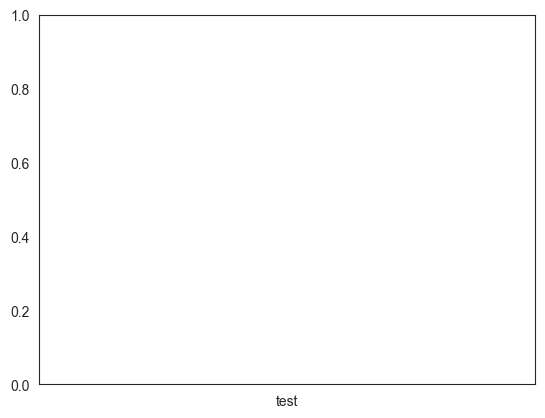

In [127]:
try:
    plot_img_stats(img_stats)
except:
    pass

### Split the dataset into 'train', 'validation', and 'test' sets

In [128]:
# !! Only run with a new image dataset !!
# Split the data into train, test, validation

def split_dataset(path, train_ratio, test_ratio, val_ratio):
    # Check ratios
    if train_ratio + test_ratio + val_ratio != 1.0:
        print_err('Please make sure the file quantity ratios add up to 1.')
        return
    
    split_folders = ['train', 'test', 'validation']
    labels = os.listdir(path)
    
    # Check if the folder structure has already been created
    if not set(labels).isdisjoint(split_folders):
        print_err('The dataset folder already contains the subfolders that you are trying to create. Please check your input folder.')
        return

    # Create folder structure
    for folder in split_folders:
        for label in labels:
            os.makedirs(name=os.path.join(path, folder, label))

    # Move image files to the appropriate subfolders
    for label in labels:
        cur_path = os.path.join(path, label)
        cur_files = os.listdir(cur_path)
        random.shuffle(cur_files)
        train_amount = int(train_ratio * len(cur_files))
        test_amount = int(test_ratio * len(cur_files))
        for c, file in enumerate(cur_files):
            file_path = os.path.join(cur_path, file)
            if c <= train_amount:
                shutil.move(file_path, os.path.join(path, 'train', label, file))
            elif c <= train_amount + test_amount:
                shutil.move(file_path, os.path.join(path, 'test', label, file))
            else:
                shutil.move(file_path, os.path.join(path, 'validation', label, file))
        
        # Delete folder if empty
        if not len(os.listdir(cur_path)):
            os.rmdir(cur_path)
        else:
            print(f'Unassigned files remaining in {cur_path}')

    return 'The dataset has been split successfully.'
    

Set a reasonable ratio for the subsets such as 60% - 20% - 20%

In [129]:
split_dataset(full_dataset_path, 0.6, 0.2, 0.2)

ERROR:
The dataset folder already contains the subfolders that you are trying to create. Please check your input folder.


## Show a summary for each subset and the amount of files

In [149]:
def get_split_stats(path):
    
    img_stats = {}

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        folder_dir = os.listdir(folder_path)
        img_stats[folder] = {}
        
        for label in folder_dir:
            label_folder_dir = os.listdir(os.path.join(folder_path, label))
            img_stats[folder][label] = len(label_folder_dir)
    
    return img_stats


Distribution of labelled images after splitting the dataset:



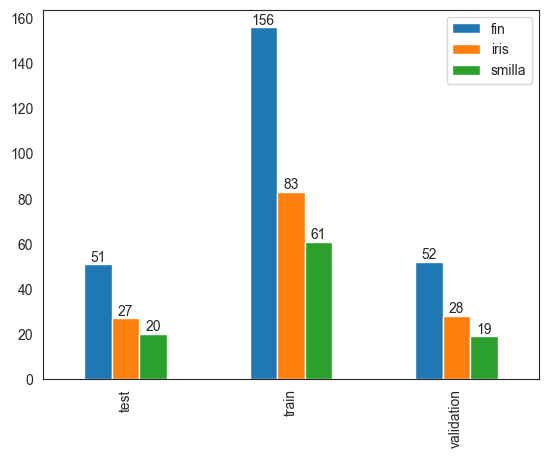

Label with the lowest amount of images:
smilla: 61
Label with the highest amount of images:
fin: 156
Difference: 95, fin has 156 % more images than smilla


In [150]:
img_stats = get_split_stats(full_dataset_path)
joblib.dump(img_stats, f'{output_path}/labels_distribution.pkl')
plot_img_stats(img_stats, after_split=True)

## Conclusion

At this point, it should be decided whether the amount and distribution of images is adequate for training the model.
If not, more image data should be collected or the data should be augmented/reduced at a later stage.

[[[  0   0   0]
  [ 50   0   0]
  [ 50  50  50]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [ 50   0   0]
  [ 50  50   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [ 50   0   0]
  [ 50  50   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[ 50  50  50]
  [ 50  50  50]
  [ 50  50  50]
  ...
  [ 50  50  50]
  [ 50  50  50]
  [100  50  50]]

 [[ 50  50  50]
  [ 50  50  50]
  [ 50  50  50]
  ...
  [ 50  50  50]
  [ 50  50  50]
  [100  50  50]]

 [[ 50  50  50]
  [ 50  50  50]
  [ 50  50  50]
  ...
  [ 50  50  50]
  [ 50  50  50]
  [100  50  50]]]


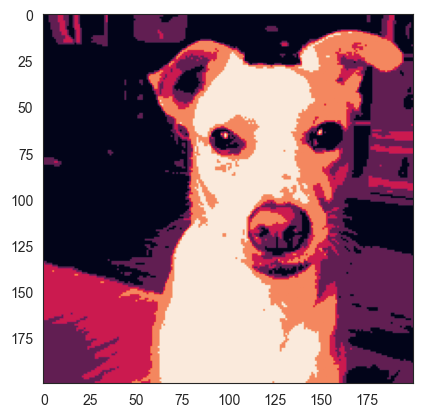

[[[ 17.  17.  17.]
  [ 14.  14.  12.]
  [ 13.  13.  11.]
  ...
  [ 60.  11.  14.]
  [ 59.  10.  13.]
  [ 57.   8.  11.]]

 [[ 15.  15.  15.]
  [ 14.  14.  12.]
  [ 11.  11.  10.]
  ...
  [ 58.   9.  12.]
  [ 62.  13.  16.]
  [ 60.  11.  14.]]

 [[ 14.  14.  15.]
  [ 13.  13.  11.]
  [ 10.  10.   9.]
  ...
  [ 59.  10.  13.]
  [ 60.  11.  14.]
  [ 59.  10.  13.]]

 ...

 [[ 64.  54.  36.]
  [ 56.  49.  33.]
  [ 52.  45.  29.]
  ...
  [183. 114.  55.]
  [184. 115.  56.]
  [183. 114.  55.]]

 [[ 61.  52.  34.]
  [ 56.  49.  33.]
  [ 51.  44.  28.]
  ...
  [183. 114.  55.]
  [183. 114.  55.]
  [184. 115.  56.]]

 [[ 58.  49.  31.]
  [ 55.  48.  31.]
  [ 50.  43.  27.]
  ...
  [183. 114.  55.]
  [184. 115.  56.]
  [185. 116.  57.]]]
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 50   0   0]
  [ 50   0   0]
  [ 50   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 50   0   0]
  [ 50   0   0]
  [ 50   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...


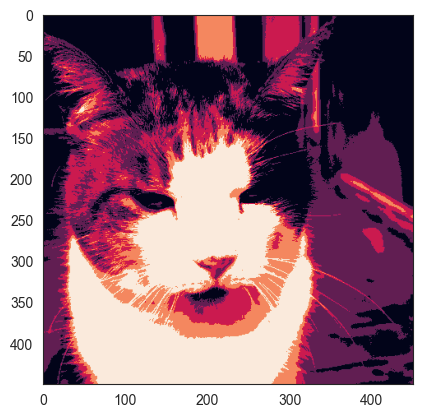

[[[203. 212. 195.]
  [202. 211. 194.]
  [203. 211. 195.]
  ...
  [217. 227. 218.]
  [216. 226. 217.]
  [217. 227. 218.]]

 [[202. 211. 194.]
  [202. 211. 194.]
  [203. 211. 194.]
  ...
  [217. 227. 218.]
  [217. 227. 218.]
  [217. 227. 218.]]

 [[202. 211. 194.]
  [202. 211. 194.]
  [203. 212. 195.]
  ...
  [217. 227. 218.]
  [218. 228. 219.]
  [218. 228. 219.]]

 ...

 [[189. 172. 182.]
  [190. 172. 183.]
  [187. 168. 180.]
  ...
  [102.  89.  64.]
  [100.  89.  64.]
  [100.  89.  62.]]

 [[196. 179. 189.]
  [194. 177. 188.]
  [194. 176. 189.]
  ...
  [102.  86.  63.]
  [101.  86.  63.]
  [100.  86.  63.]]

 [[198. 180. 191.]
  [197. 181. 192.]
  [195. 180. 194.]
  ...
  [101.  83.  63.]
  [102.  84.  65.]
  [101.  85.  64.]]]
[[[150 200 100]
  [150 150 100]
  [150 150 100]
  ...
  [200 200 200]
  [200 200 200]
  [200 200 200]]

 [[150 150 100]
  [150 150 100]
  [150 150 100]
  ...
  [200 200 200]
  [200 200 200]
  [200 200 200]]

 [[150 150 100]
  [150 150 100]
  [150 200 100]
  ...


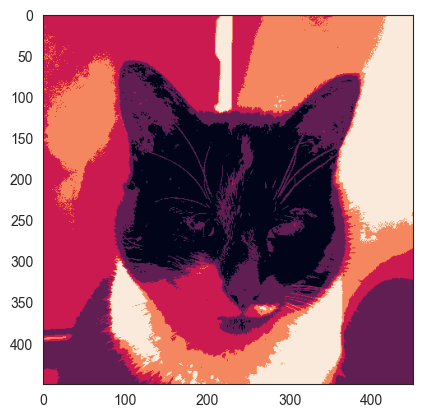

ValueError: operands could not be broadcast together with shapes (200,200) (450,450) 

In [63]:
# IGNORE, Experimenting

import tensorflow as tf

with Image.open("inputs/datasets/pets/fin/fin (199).png") as img:
    #img.show()
    print(image.img_to_array(img))
    #img = image.img_to_array(img.resize((200,200),resample=Image.LANCZOS))
    
    disc = tf.keras.layers.Discretization(
        #bin_boundaries=[0.,100.,255.],
        num_bins=5,
        epsilon=0.01,
        output_mode='int',
        sparse=False,
        #dtype=None,
        #name=None
    )
    disc.adapt(img)
    new_img = np.array(disc(img)).astype('int')
    #print(new_img)
    new_new_img = np.array(new_img * 50)
    fin = new_new_img[...,2]
    print(new_new_img)
    plt.imshow(fin)
    plt.show()
    
with Image.open("inputs/datasets/pets/iris/iris (256).png") as img:
    #img.show()
    print(image.img_to_array(img))
    
    disc = tf.keras.layers.Discretization(
        #bin_boundaries=[0.,100.,255.],
        num_bins=5,
        epsilon=0.01,
        output_mode='int',
        sparse=False,
        #dtype=None,
        #name=None
    )
    disc.adapt(img)
    new_img = np.array(disc(img)).astype('int')
    #print(new_img)
    new_new_img = np.array(new_img * 50)
    iris = new_new_img[...,2]
    print(new_new_img)
    plt.imshow(iris)
    plt.show()
    
with Image.open("inputs/datasets/pets/smilla/smilla (267).png") as img:
    #img.show()
    print(image.img_to_array(img))
    
    disc = tf.keras.layers.Discretization(
        #bin_boundaries=[0.,100.,255.],
        num_bins=5,
        epsilon=0.01,
        output_mode='int',
        sparse=False,
        #dtype=None,
        #name=None
    )
    disc.adapt(img)
    new_img = np.array(disc(img)).astype('int')
    #print(new_img)
    new_new_img = np.array(new_img * 50)
    smilla = new_new_img[...,2]
    print(new_new_img)
    plt.imshow(smilla)
    plt.show()
    
diff = np.abs(fin - iris - smilla)
print(diff)
plt.imshow(diff)
plt.show()

means = np.mean([smilla, fin], axis=0)
plt.imshow(means, cmap='grey')
plt.show()
